In [1]:
from kdap.converter.wikiConverter import wikiConverter
import xmltodict
from datetime import date
import mwparserfromhell
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [2]:
article = 'Indian Institute of Technology Ropar'
wikiConverter.getArticle(file_name = article, output_dir = 'wiki')

Indian Institute of Technology Ropar Completed!


In [3]:
bots = ['Cydebot',
 'InternetArchiveBot',
 'WP .0 bot',
 'SmackBot',
 'Yobot',
 'ClueBot NG',
 'Addbot',
 'SineBot',
 'EmausBot',
 'ClueBot',
 'RjwilmsiBot',
 'AnomieBOT',
 'Xqbot',
 'RussBot',
 'Fbot',
 'Luckas-bot',
 'BetacommandBot',
 'The Anomebot2',
 'COIBot',
 'Lightbot',
 'AlexNewArtBot',
 'ZéroBot',
 'Helpful Pixie Bot',
 'OrphanBot',
 'BattyBot',
 'FrescoBot',
 'MiszaBot III',
 'Legobot',
 'SporkBot',
 'TXiKiBoT',
 'XLinkBot',
 'VeblenBot',
 'AvicBot',
 'AAlertBot',
 'ListasBot',
 'Thijs!bot',
 'VolkovBot',
 'Kingbotk',
 'Erik9bot',
 'Alaibot',
 'SieBot',
 'TedderBot',
 'CommonsDelinker',
 'BOTijo',
 'Xenobot Mk V',
 'D6',
 'ClueBot III',
 'BG9bot',
 'EdwardsBot',
 'Bluebot',
 'Mathbot',
 'CmdrObot',
 'DASHBot',
 'Full-date unlinking bot',
 'BotMultichill',
 'Citation bot',
 'YurikBot',
 'VoABot II',
 'ImageRemovalBot',
 'BJBot',
 'MiszaBot II',
 'Eubot',
 'ArthurBot',
 'AntiVandalBot',
 'HasteurBot',
 'HBC AIV helperbot7',
 'VIAFbot',
 'MiszaBot I',
 'Escarbot',
 'SoxBot',
 'Cyberbot I',
 'MetsBot',
 'DeltaQuadBot',
 'DPL bot',
 'FlaBot',
 'RFC bot',
 'DumZiBoT',
 'Polbot',
 'STBotI',
 'Xenobot',
 'Alexbot',
 'KrimpBot',
 'MartinBot',
 'Kbdankbot',
 'ImageTaggingBot',
 'Femto Bot',
 'MGA73bot',
 'MystBot',
 'YFdyh-bot',
 'CorenSearchBot',
 'Chobot',
 'HBC Archive Indexerbot',
 'ProteinBoxBot',
 'Kumi-Taskbot',
 'Kotbot',
 'JAnDbot',
 'Monkbot',
 'DrilBot',
 'GrouchoBot',
 'DumbBOT',
 'Zorrobot',
 'WikitanvirBot',
 'FairuseBot',
 'WildBot',
 'HBC AIV helperbot3',
 'Rambot',
 'RedBot',
 'タチコマ robot',
 'NoomBot',
 'MartinBotIII',
 'DodoBot',
 'TinucherianBot',
 'H3llBot',
 'CheMoBot',
 'Tawkerbot2',
 'Citation bot ',
 'ShepBot',
 'Reedy Bot',
 'GA bot',
 'InceptionBot',
 'Detroiterbot',
 'LaaknorBot',
 'SkiersBot',
 'Chris G Bot 3',
 'LaraBot',
 'Lowercase sigmabot III',
 'SatyrBot',
 'Ganeshbot',
 'HBC AIV helperbot5',
 'DYKUpdateBot',
 'Svenbot',
 'BryanBot',
 'BracketBot',
 'Tawkerbot',
 'Pearle',
 'Hmainsbot',
 'PseudoBot',
 'JL-Bot',
 'DarknessBot',
 'ChuispastonBot',
 'OKBot',
 'Makecat-bot',
 'LucienBOT',
 'Alphachimpbot',
 '78 Bot',
 'Snotbot',
 'Scsbot',
 'KLBot2',
 'HagermanBot',
 'Numbo3-bot',
 '28bot',
 'AlleborgoBot',
 'Robbot',
 'EarwigBot',
 'HostBot',
 'Rei-bot',
 'Hazard-Bot',
 'DFBot',
 'RM bot',
 'RobotG',
 'Wikinews Importer Bot',
 'The wubbot',
 'BotMultichillT',
 'MiszaBot',
 'CactusBot',
 'DSisyphBot',
 'AvocatoBot',
 'ArticlesForCreationBot',
 'BrownBot',
 'GimmeBot',
 'CanisRufus',
 'Mr.Z-bot',
 'RibotBOT',
 'Redirect fixer',
 'MadmanBot',
 'STBot',
 'Ptbotgourou',
 'PhotoCatBot',
 "Theo's Little Bot",
 'DYKHousekeepingBot',
 'ArticleAlertbot',
 'Amalthea (bot)',
 'MastiBot',
 'Erwin85Bot',
 'SQLBot',
 'RMCD bot',
 'Werdnabot',
 'Thehelpfulbot',
 'Ralbot',
 'SoxBot V',
 'Amirobot',
 'DragonBot',
 'STTWbot',
 'MelonBot',
 'CommonsNotificationBot',
 'FoxBot',
 'BAGBot',
 'Sambot',
 'ClueBot II',
 'Idioma-bot',
 'TuHan-Bot',
 'MalafayaBot',
 'MediaWiki message delivery',
 'Staeckerbot',
 'HRoestBot',
 'KamikazeBot',
 'JackieBot',
 'SuggestBot',
 'Maelgwnbot',
 'VoxelBot',
 "Uncle G's major work 'bot",
 'Shadowbot3',
 'Drinibot',
 'PotatoBot',
 'Rezabot',
 'MarshBot',
 'BogBot',
 'Cyberbot II',
 'DefaultsortBot',
 'SharedIPArchiveBot',
 'Tangobot',
 'PixelBot',
 'Thadius856AWB',
 'TPBot',
 'DyceBot',
 'WatchlistBot',
 'Gdrbot',
 'SDPatrolBot',
 'DOI bot',
 'ArmbrustBot',
 'SashatoBot',
 'TobeBot',
 'AntiSpamBot',
 'SassoBot',
 'JYBot',
 'Rubinbot',
 'People-photo-bot',
 'LivingBot',
 'SilvonenBot',
 'MenasimBot',
 'Sandbot',
 'Muro Bot',
 'DinoBot2',
 'AP.BOT',
 'BotanyBot',
 'Sethbot',
 'Jogersbot',
 'Obersachsebot',
 'Petan-Bot',
 'BernsteinBot',
 'SteveBot',
 'ChzzBot IV',
 'WinBot',
 'STBotD',
 'ContinuityBot',
 'HBC AIV helperbot2',
 'Eskimbot',
 'Ohms Law Bot',
 'Δbot',
 "D'ohBot",
 'DHN-bot',
 'J Milburn Bot',
 'Ripchip Bot',
 'FeedBot',
 'PipepBot',
 'KingpinBot',
 'AdminStatsBot',
 'Scepbot',
 'OgreBot',
 'BOTarate',
 'One bot',
 'Guanabot',
 'CapitalBot',
 'KevinBot',
 'SPCUClerkbot',
 'MifterBot I',
 'HBC NameWatcherBot',
 'CSDWarnBot',
 'AMbot',
 'SoxBot III',
 'VoABot',
 'Curpsbot-unicodify',
 'JeffGBot',
 'TjBot',
 'Commander Keane bot',
 'TaBOT-zerem',
 'HBC AIV helperbot',
 'MerlIwBot',
 'Android Mouse Bot 2',
 'LyricsBot',
 'Mjbmrbot',
 'Whobot',
 'PbBot',
 'Gnome (Bot)',
 'BoxCrawler',
 'KarlsenBot',
 'JBradley Bot',
 'COBot',
 'Lowercase sigmabot',
 'Chartbot',
 'Broadbot',
 'Phe-bot',
 'A4bot',
 'Comics-awb',
 'DYKadminBot',
 'JoeBot',
 'Dinamik-bot',
 '.anacondabot',
 'JhsBot',
 'DASHBotAV',
 'Snowbot',
 'ChzzBot II',
 'RonaldBot',
 'AfDBot',
 'RBot',
 'MPUploadBot',
 '^demonBot2',
 'John Bot',
 'AWeenieBot',
 'HBC AIV helperbot4',
 'Pegasusbot',
 'Synthebot',
 'OverlordQBot',
 'AndersBot',
 'WikiStatsBOT',
 'Rick Bot',
 'BOT-Superzerocool',
 'Vagobot',
 'CarsracBot',
 'Tawkerbot4',
 'MessedRobot',
 'SpBot',
 'EmxBot',
 'AlnoktaBOT',
 'WelcomerBot',
 'Filedelinkerbot',
 'Legobot II',
 'BenzolBot',
 'SoxBot II',
 'BorgardeBot',
 'SoxBot IV',
 'Vina-iwbot',
 'Seedbot',
 'RoboMaxCyberSem',
 'Zwobot',
 'JaGaBot',
 'Lowercase sigmabot II',
 'Arbitrarily0Bot',
 'Rschen7754bot',
 'Grafikbot',
 'Taxobot ',
 'Bibcode Bot',
 'VWBot',
 'MerlLinkBot',
 'SQLBot-Hello',
 'CobraBot',
 'Locobot',
 'LordAnubisBOT',
 'MBisanzBot',
 'MenoBot',
 'Kyle the bot',
 'LostBot',
 'PeerReviewBot',
 'EdoBot',
 'SelketBot',
 'Bot058',
 'Justincheng2345-bot',
 'UnCatBot',
 'Sagabot',
 'MifterBot',
 'XLerateBot',
 'XyBot',
 'Roboto de Ajvol',
 'Alph Bot',
 'NW557Bot',
 'NjardarBot',
 'Giggabot',
 'RobotE',
 'KnightRider',
 'DorganBot',
 'KocjoBot',
 'WPArkansas Bot',
 'GrinBot',
 'Fluxbot',
 'MondalorBot',
 'CounterVandalismBot',
 'Citation bot 2',
 'MauritsBot',
 'WeggeBot',
 'FlBot',
 'Jumbuck',
 'NetBot',
 'Zorglbot',
 'MSBOT',
 'KevinalewisBot',
 'Lucasbfrbot',
 'RebelRobot',
 'Taxobot 7',
 'JdforresterBot',
 'RaptureBot',
 'DixonDBot',
 'Chem-awb',
 'ZhBot',
 'CitationCleanerBot',
 'Tsca.bot',
 'Anybot',
 'NationalRegisterBot',
 'Bot062',
 'Almabot',
 "Tom's Tagging Bot",
 'LinkFA-Bot',
 'ArkyBot',
 'TechBot',
 'AccReqBot',
 'Mairibot',
 'CopyToWiktionaryBot',
 'BotKung',
 'RoryBot',
 'SD5bot',
 'Bota47',
 'HiW-Bot',
 'MoohanBOT',
 'CocuBot',
 'Ligulembot',
 'HersfoldArbClerkBot',
 'Acebot',
 'RockfangBot',
 'Gerakibot',
 'Chlewbot',
 'AkhtaBot',
 'Crypticbot',
 'SteenthIWbot',
 'Luasóg bot',
 "Jitse's bot",
 'SamatBot',
 'Kasirbot',
 'MenoBot II',
 'MessageDeliveryBot',
 'Syrcatbot',
 'RileyBot',
 'HerculeBot',
 'Cerabot',
 'CrimsonBot',
 'HBC AIV helperbot',
 'YpnBot',
 'StigBot',
 'KslotteBot',
 'Mentibot',
 'John Bot III',
 'DarafshBot',
 'Anchor Link Bot',
 'BHGbot',
 'McM.bot',
 'ReferenceBot',
 'StatisticianBot',
 'Chris G Bot',
 'Louperibot',
 'El bot de la dieta',
 'HtonlBot',
 'JCbot',
 'Peelbot',
 'VVVBot',
 'Pageview bot',
 'WebCiteBOT',
 'Wherebot',
 'GargoyleBot',
 'IluvatarBot',
 'BrokenAnchorBot',
 'HotArticlesBot',
 'KittyBot',
 'ENewsBot',
 'EarwigBot I',
 'VixDaemonBot',
 'Pokbot',
 'FlagBot',
 'SpellingBot',
 'PDFbot',
 'LatitudeBot',
 'Aksibot',
 'Estirabot',
 'Maksim-bot',
 'Nallimbot',
 'Image-req-proj-bot',
 'AFD Bot',
 'GurchBot',
 'ImageBacklogBot',
 'ClueBot VI',
 "Uncle G's 'bot",
 'PNG crusade bot',
 'TPO-bot',
 'DomBot',
 'Ebrambot',
 'Margosbot',
 'StatusBot',
 'Jotterbot',
 'AlanBOT',
 'AnkitAWB',
 'EarwigBot III',
 'EBot IV',
 'RscprinterBot',
 'DeadBot',
 'Purbo T',
 'SeveroBot',
 'Le Pied-bot',
 'NedBot',
 'BodhisattvaBot',
 'CountryBot',
 'FileBot',
 'AfDStatBot',
 'MTSbot',
 'ChenzwBot',
 'EssjayBot',
 'BenoniBot',
 'SEWilcoBot',
 'VedeBOT',
 'YonaBot',
 'MMABot',
 "Martin's bot",
 'WikiDreamer Bot',
 'NTBot',
 'Movses-bot',
 'HasharBot',
 'LawBot',
 'Kakashi Bot',
 'UcuchaBot',
 "Milk's Favorite Bot",
 'BotPuppet',
 'Lt-wiki-bot',
 'WolterBot',
 'Android Mouse Bot 3',
 'EBot II',
 'XZeroBot',
 'RefDeskBot',
 'CohesionBot',
 'PlangeBot',
 'TuvicBot',
 'Merge bot',
 'Andrea05Bot',
 'TinucherianBot II',
 'Hxhbot',
 'Skumarlabot',
 'AmphBot',
 'Beastie Bot',
 'ClickBot',
 'GeorgeMoneyBot-status',
 'ZsinjBot',
 'JVbot',
 'NukeBot',
 'GhalyBot',
 'KaiserbBot',
 'PlankBot',
 'Nobot',
 'HBC AIV helperbot 8',
 'NolBot',
 'WuBot',
 'Ugur Basak Bot',
 'Pathosbot',
 'Mgmbot',
 'FANSTARbot',
 'Sahimrobot',
 'MuZebot',
 'SelectionBot',
 'ARSBot',
 'JamietwBot',
 'EleferenBot',
 'Adlerbot',
 'SundarBot',
 'Android Mouse Bot',
 'SoxBot VI',
 'AdambroBot',
 'ClueBot Commons',
 'People-n-photo-bot',
 'OldMedcabBot',
 'Image Screening Bot',
 'WolfBot',
 'WarddrBOT',
 'ToePeu.bot',
 'PolarBot',
 'SoxBot VIII',
 'Minsbot',
 'AstaBOTh5',
 'MonoBot',
 'DYKBot',
 'ChandlerMapBot',
 'R Delivery Bot',
 'Yonidebot',
 'AvicBot2',
 'DcoetzeeBot',
 'Albambot',
 'Swimmingbot-awb',
 'DirlBot',
 'Elissonbot',
 'FiriBot',
 'Josvebot',
 'BepBot',
 'Citation bot 3',
 'MartinBotIV',
 'Vini 7bot5',
 'ClueBot IV',
 'Taxobot 2',
 'PDBbot',
 'Amolbot',
 'MediationBot',
 'ImageTagBot',
 'Ryan Vesey Bot',
 'H92Bot',
 'Tanhabot',
 'Diego Grez Bot',
 'Lucia Bot',
 'Signpost Book Bot',
 'Byrialbot',
 'NodBot',
 'Bot-Schafter',
 'Bot523',
 'Philosopher-Bot',
 'AnomieBOT II',
 'DustyBot',
 'Chrisbot',
 'BetBot',
 'MahdiBot',
 'Commons fair use upload bot',
 'Blood Oath Bot',
 'TottyBot',
 'Kl4m-AWB',
 'RFRBot',
 'AstRoBot',
 'AmeliorationBot',
 'CeraBot',
 'Bikabot',
 'LDBot',
 'NrhpBot',
 'Bocianski.bot',
 'FaleBot',
 'Zxabot',
 'CrazynasBot',
 'IPTaggerBot',
 'HarrivBOT',
 'Ver-bot',
 'Rfambot',
 'SvickBOT',
 'Kwjbot',
 'Ocobot',
 'KolBot',
 'PascalBot',
 'SpillingBot',
 'CricketBot',
 'SoxBot X',
 'RobotJcb',
 'EnzaiBot',
 'ListGenBot',
 'WikiBotas',
 'Wybot',
 'Peti60botH',
 'Plasticbot',
 'FPBot',
 'Robert SkyBot',
 'Italic title bot',
 'Android Mouse Bot 4',
 'GrooveBot',
 'NekoBot',
 'RoboServien',
 'SMS Bot',
 'SoxBot VII',
 'AzaBot',
 'BotdeSki',
 'Slobot',
 'Eivindbot',
 'Snaevar-bot',
 'AilurophobiaBot',
 'DeadLinkBOT',
 'BendelacBOT',
 'Kisbesbot',
 'Citation bot 4',
 'O bot',
 'Manishbot',
 'AudeBot',
 'SheepBot',
 'Nixbot',
 'WoodwardBot',
 'MastersBot',
 'GracenotesBot',
 'AntiAbuseBot',
 'WxBot',
 'Janna Isabot',
 'Analphabot',
 'SantoshBot',
 '7SeriesBOT',
 'Legobot III',
 'DinoBot',
 'Botpankonin',
 'Ficbot',
 'SwiftBot',
 'Rameshngbot',
 'AndreasJSbot',
 'SDPatrolBot II',
 'EBot',
 'Alirezabot',
 'Razibot',
 'Anibot',
 'NobelBot',
 'Nono le petit robot',
 'Mulder46sBot',
 'TARBOT',
 'MCBot',
 'TTObot',
 'WODUPbot',
 'NeuRobot',
 'WaldirBot',
 'Antischmitzbot',
 'Taxobot',
 'VP-bot',
 'MedcabBot',
 'ChzzBot',
 "Joe's Olympic Bot",
 'Fajrbot',
 'ElMeBot',
 'Stwalkerbot',
 'SprinterBot',
 'AutocracyBot',
 'MartinBotII',
 'Stefan2bot',
 'GnawnBot',
 'DpmukBOT',
 'AnomieBOT III',
 'MandelBot',
 'Caypartisbot',
 'ChessBOT',
 'GZ-Bot',
 'PsychAWB',
 'TypoBot',
 'Newsletterbot',
 'Danumberbot',
 'Robotic Garden',
 'Dark Shikari Bot',
 'BotCompuGeek',
 'DEagleBot',
 'NeraBot',
 'AlptaBot',
 'Halibott',
 'SpaceFactsBot',
 'VsBot',
 'Diligent Terrier Bot',
 'Riccardobot',
 'Kal-El-Bot',
 'Luuvabot',
 'UncatTemplateBot',
 'Botx',
 'Naudefjbot',
 'DrTrigonBot',
 'DrFO.Tn.Bot',
 'Selmobot',
 'DavidWSBot',
 'HujiBot',
 'BenjBot',
 'BoricuaBot',
 'DefconBot',
 'ListManBot',
 'AHbot',
 'AsgardBot',
 'Manubot',
 'Sumibot',
 'Madhubot',
 'JJBot',
 'RSElectionBot',
 'FritzpollBot',
 'KaldariBot',
 'NilfaBot',
 'MalarzBOT',
 'Simplebot',
 'AloysiusLiliusBot',
 'EddieBot',
 'PALZ9000',
 'OrophinBot',
 'AZatBot',
 'Denbot',
 "Milk's Favorite Bot II",
 'Pfft Bot',
 'SVGBot',
 'VeinorBot',
 'AswnBot',
 'Rtz-bot',
 'QOTDBot',
 'MrVanBot',
 'PaievBot',
 'IcalaniseBot',
 'QualiaBot',
 'KuduBot',
 'DeliveryBot',
 'LSG-Bot',
 'Egmontbot',
 'PCbot',
 'APersonBot',
 'XeBot',
 'JMuniBot',
 'BücherBot',
 'SusBot',
 'Botryoidal',
 'MichaelBillingtonBot',
 'The Anonybot',
 'ReigneBOT',
 'ChzzBot III',
 'HMBot',
 'Kgsbot',
 'DottyQuoteBot',
 'OpenlibraryBot',
 'SandgemBot',
 'Kaspobot',
 'Kumar Appaiah Bot',
 'MauchoBot',
 'WMUKBot',
 'SharafBot',
 'Rabbot',
 'Pattonbot',
 'The Auto-categorizing Robot',
 'SamuraiBot',
 'StormBot',
 'DusterBot',
 'H2Bot',
 'EagleAstroidBot',
 'Rob078bot',
 'SpeedyBot',
 'Homobot',
 'SVnaGBot',
 'Lockalbot',
 'GeorgeMoneyBot',
 'StatsBot',
 'Fettgesicht',
 'CSBot',
 'EBot III',
 'Cherybot',
 'TaeBot',
 'RFC posting script',
 'Project Messenger Bot',
 'MotinBot',
 'WilhelmBot',
 'DinoSizedBot',
 'DanielBot',
 'DarioBot',
 'Bersibot',
 'Sgeo-BOT',
 'ViskonBot',
 'DvyBot',
 'ArbComBot',
 'JerryBot',
 'UltraBot',
 'Z-BOT',
 'YekratsBot',
 'EberBot',
 'R. Hillgentleman',
 'OrBot',
 'CataBotTsirel',
 'Smallbot',
 'Mihas-bot',
 'Orphaned image deletion bot',
 'SPPatrolBot',
 'Danielfolsom2.bot',
 'TAP Bot',
 'TFA Protector Bot',
 'DRN clerk bot',
 'Dpkbot',
 'M-Bot',
 'CleanupListingBot',
 'IPLRecordsUpdateBot',
 'SpebiBot',
 'AwOcBot',
 'Town-bot',
 'TorNodeBot',
 'CloudNineBot',
 'SebrevBOT',
 'SpellCheckerBot',
 'Wikipedia Signpost',
 'AEBot',
 'Heikobot',
 'MessengerBot',
 'WASDbot',
 'NVS(bot)',
 'Wpp research bot',
 'GrashoofdBot',
 'WalkingSoulBot',
 'CommonsNotification',
 'CwraschkeDataBot',
 'Nomenclaturebrowser',
 'PC78-bot',
 'SunCreatorBot',
 'WillieBot',
 'KyluBot',
 'ChrisSalij Bot',
 'Taxobot 6',
 'Taxobot 3',
 'Geimas5Bot',
 'BsherrAWBBOT',
 'MetaplasticityBot',
 'AlekseyBot',
 'TowBot',
 'Taxobot (usurped)',
 'SlakrBot',
 'ZscoutBot',
 'JatBot',
 'Non-Free Content Compliance Bot',
 "Joe's Null Bot",
 'Collabsearch',
 'ProcseeBot',
 'AttributionBot']

In [37]:
class wikiStats :
    
    #GENERAL STATISTICS
    def __init__(self, article) :
        self.di = xmltodict.parse(open('./wiki/'+article+'.xml',"r").read())
        self.revisions = [x for x in self.di['mediawiki']['page']['revision']] 
        self.editors = {}
        self.botEditors = {}
        for x in self.revisions :
            username = x['contributor']['username'] if 'username' in x['contributor'] else x['contributor']['ip']
            if username not in bots:
                if username in self.editors :
                    self.editors[username] += 1
                else :
                    self.editors[username] = 1
            else :
                if username in self.botEditors :
                    self.botEditors[username] += 1
                else :
                    self.botEditors[username] = 1 

    def getID(self) :
        return self.di['mediawiki']['page']['id']
            
    def getTotalEdits(self) :
        return len(self.revisions) 
    
    def getMinorEdits(self) :
        i = 0
        for x in self.revisions :
            if 'minor' in x :
                i += 1
        return i
    
    def getIPEdits(self) :
        i = 0
        for x in self.revisions :
            if 'ip' in x['contributor'] :
                i += 1
        return i
    
    def getBotEdits(self) :
        ans = 0
        for bot in self.botEditors.keys() :
            ans += self.botEditors[bot]
        return ans
    
    def getEditors(self) :
        return len(self.editors) + len(self.botEditors)
    
    def getPageSize(self) :
        return self.revisions[-1]['text']['@bytes']
    
    def getFirstEdit(self) :
        di = {}
        di['user'] = self.revisions[0]['contributor']['username'] if 'username' in self.revisions[0]['contributor'] else self.revisions[0]['contributor']['ip']
        di['time'] = self.revisions[0]['timestamp']
        di['text added'] = self.revisions[0]['text']['@bytes']
        return di
    
    def getLastEdit(self) :
        di = {}
        di['user'] = self.revisions[-1]['contributor']['username'] if 'username' in self.revisions[-1]['contributor'] else self.revisions[-1]['contributor']['ip']
        di['time'] = self.revisions[-1]['timestamp']
        try :
            di['text added'] = int(self.revisions[-1]['text']['@bytes']) - int(self.revisions[-2]['text']['@bytes'])
        except :
            di['text added'] = self.revisions[0]['text']['@bytes']
        return di
    
    def getMaxTextAdded(self) :
        di = {}
        di['user'] = self.revisions[0]['contributor']['username'] if 'username' in self.revisions[0]['contributor'] else self.revisions[0]['contributor']['ip']
        di['time'] = self.revisions[0]['timestamp']
        di['text added'] = int(self.revisions[0]['text']['@bytes'])
        for i in range(1, len(self.revisions)) :
            temp = int(self.revisions[i]['text']['@bytes']) - int(self.revisions[i-1]['text']['@bytes'])
            if temp > di['text added'] :
                di['user'] = self.revisions[i]['contributor']['username'] if 'username' in self.revisions[i]['contributor'] else self.revisions[i]['contributor']['ip']
                di['time'] = self.revisions[i]['timestamp']  
                di['text added'] = temp
        return di
    
    def getMaxTextDeleted(self) :
        di = {}
        di['text deleted'] = 0
        for i in range(1, len(self.revisions)) :
            temp = int(self.revisions[i]['text']['@bytes']) - int(self.revisions[i-1]['text']['@bytes'])
            if temp < di['text deleted'] :
                di['user'] = self.revisions[i]['contributor']['username'] if 'username' in self.revisions[i]['contributor'] else self.revisions[i]['contributor']['ip']
                di['time'] = self.revisions[i]['timestamp']  
                di['text deleted'] = temp
        return di
    
    #EDITS 
    def getAverageEditsPerUser(self) :
        return self.getTotalEdits()/self.getEditors()
    
    def getAverageTimeBetweenEdits(self) :
        timestamps = [ di['mediawiki']['page']['revision'][i]['timestamp'] for i in range(len(di['mediawiki']['page']['revision']))]
        times = [date(year = int(timestamps[i][:4]), month = int(timestamps[i][5:7]), day = int(timestamps[i][8:10])) for i in range(len(timestamps))]
        timeDiff = date(1, 1, 1) - date(1, 1, 1)
        for i in range(len(times)-1) :
            timeDiff += times[i+1] - times[i]
        return timeDiff.days/(len(times)-1)
    
    def getAverageEditsPerDay(self) :
        t1 = self.getFirstEdit()['time']
        t1 = date(year = int(t1[:4]), month = int(t1[5:7]), day = int(t1[8:10]))
        t2 = datetime.date.today()
        return self.getTotalEdits()/(t2-t1).days
    
    def getAverageEditsPerMonth(self) :
        return 30*self.getAverageEditsPerDay()
    
    def getAverageEditsPerYear(self) :
        return 365*self.getAverageEditsPerDay()
    
    def getEditsInPastXDays(self, x) :
        timestamps = [ di['mediawiki']['page']['revision'][i]['timestamp'] for i in range(len(di['mediawiki']['page']['revision']))]
        times = [date(year = int(timestamps[i][:4]), month = int(timestamps[i][5:7]), day = int(timestamps[i][8:10])) for i in range(len(timestamps))]
        t0 = datetime.date.today()
        count = 0
        for i in range(len(times)-1, -1, -1) :
            t = times[i]
            tDiff = t0 - t
            if tDiff.days > x :
                break
            else :
                count += 1
        return count
        
    def getEditsInPast24Hours(self) :
        return self.getEditsInPastXDays(x = 1)
    
    def getEditsInPast7Days(self) :
        return self.getEditsInPastXDays(x = 7)
        
    def getEditsInPast30Days(self) :
        return self.getEditsInPastXDays(x = 30)
    
    def getEditsInPast365Days(self) :
        return self.getEditsInPastXDays(x = 365)
    
    def getEditsByTop10Editors(self) :
        arr = []
        for x in self.editors.keys() :
            arr.append(self.editors[x])
        arr.sort(reverse = True)
        top10Edits = 0
        for i in range(10) :
            try :
                top10Edits += arr[i]
            except :
                break
        return top10Edits
    
    #charts
    def getMajorMinorGraph(self) :
        labels = ["Major edits","Minor Edits"]
        values = [self.getTotalEdits() - self.getMinorEdits(), self.getMinorEdits()]
        colors = ['#abd4eb', "#b2df8a"]
        explode = [0.01, 0.01]
        for i in range(len(labels)) :
            labels[i] = labels[i] + " · " + str(values[i])

        legend_elements = [ Line2D([0], [0], marker='o', color='w', markersize=15,
                    label=labels[i],  markerfacecolor=colors[i]) for i in range(len(labels))]

        plt.axis("equal")
        plt.pie(values, colors = colors, explode = explode, autopct = '%0.1f%%', startangle=90, counterclock = False)
        plt.legend(labels, handles=legend_elements, loc="center left", fontsize = 12, frameon = False, bbox_to_anchor=(1, 0, 0.5, 1))

        plt.show()
    
    def getAccountIPGraph(self) :
        labels = ["Accounts","IPs"]
        values = [self.getTotalEdits() - self.getIPEdits(), self.getIPEdits()]
        colors = ['#abd4eb', "#b2df8a"]
        explode = [0.01, 0.01]
        for i in range(len(labels)) :
            labels[i] = labels[i] + " · " + str(values[i])

        legend_elements = [ Line2D([0], [0], marker='o', color='w', markersize=15,
                    label=labels[i],  markerfacecolor=colors[i]) for i in range(len(labels))]

        plt.axis("equal")
        plt.pie(values, colors = colors, explode = explode, autopct = '%0.1f%%', startangle=90, counterclock = False)
        plt.legend(labels, handles=legend_elements, loc="center left", fontsize = 12, frameon = False, bbox_to_anchor=(1, 0, 0.5, 1))

        plt.show()
        
    def getTop10Bottom90Graph(self) :
        labels = ["Top 10% ","Bottom 90%"]
        values = [self.getEditsByTop10Editors(), self.getTotalEdits() - self.getEditsByTop10Editors()]
        colors = ['#abd4eb', "#b2df8a"]
        explode = [0.01, 0.01]
        for i in range(len(labels)) :
            labels[i] = labels[i] + " · " + str(values[i])

        legend_elements = [ Line2D([0], [0], marker='o', color='w', markersize=15,
                    label=labels[i],  markerfacecolor=colors[i]) for i in range(len(labels))]

        plt.axis("equal")
        plt.pie(values, colors = colors, explode = explode, autopct = '%0.1f%%', startangle=90, counterclock = False)
        plt.legend(labels, handles=legend_elements, loc="center left", fontsize = 12, frameon = False, bbox_to_anchor=(1, 0, 0.5, 1))

        plt.show()
    
    def modifyEditors(self) :
        for x in revisions :
            

In [38]:
stats = wikiStats(article)

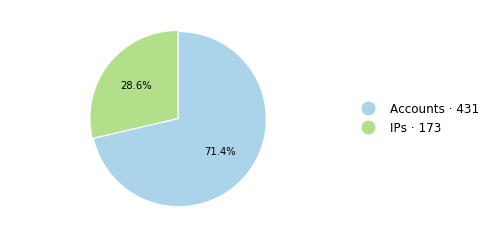

In [39]:
stats.getAccountIPGraph()

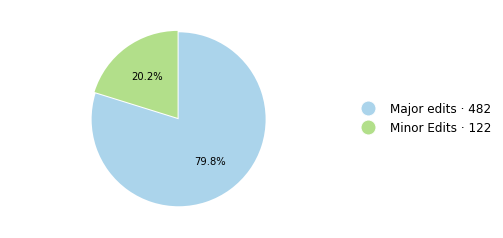

In [40]:
stats.getMajorMinorGraph()

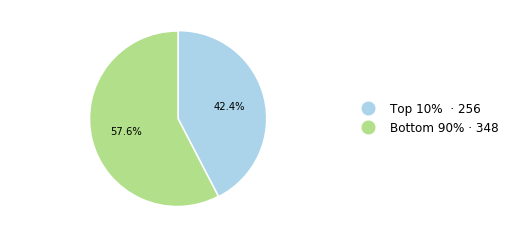

In [41]:
stats.getTop10Bottom90Graph()

In [269]:
di = xmltodict.parse(open('./wiki/'+article+'.xml',"r").read())
text = di['mediawiki']['page']['revision'][-1]['text']['#text']
wikicode = mwparserfromhell.parse(text)

In [42]:
stats.editors

{'Quality check': 13,
 'Ka Faraq Gatri': 1,
 'Lightmouse': 2,
 'IndianGeneralist': 2,
 'Jamesontai': 1,
 'GDibyendu': 2,
 'Shyamsunder': 1,
 'Fuddubande': 6,
 'Miq': 1,
 '203.109.121.73': 1,
 'PamD': 1,
 'Auntof6': 1,
 'Iitmsriram': 7,
 '59.178.202.77': 2,
 'Rockstar1800': 1,
 '59.180.220.122': 1,
 'Tim1357': 1,
 'Joy': 1,
 'Dirtysuits': 9,
 'Yugdeep': 1,
 'Urprakhar': 1,
 'Extra999': 4,
 'Siddhant': 1,
 'GTBacchus': 1,
 '59.182.73.5': 1,
 'BestIITian': 1,
 '117.197.129.226': 1,
 '117.197.122.49': 1,
 'Anthony Appleyard': 1,
 '59.90.71.81': 2,
 '165.68.219.54': 2,
 '99.23.151.210': 4,
 'Chiraggupta1990': 18,
 '117.197.113.34': 1,
 'Ravitejamulpuru': 1,
 'Woohookitty': 1,
 'Mindprince rohit': 18,
 'Chris the speller': 3,
 '164.100.170.4': 5,
 'Sahil bhagat': 1,
 'Tahir sheikh2006': 2,
 'Akshatrathi294': 1,
 'Hariehkr': 2,
 'Mild Bill Hiccup': 1,
 '59.98.208.10': 8,
 'Rahuldhingra92': 1,
 '59.98.208.128': 2,
 'EngineerFromVega': 1,
 '203.200.225.155': 1,
 'Piyushnahar1991': 1,
 'Roland z

In [267]:
print(wikicode.filter_templates())

['{{Use British English|date=March 2013}}', '{{Use dmy dates|date=March 2013}}', '{{Infobox university\n| name = Indian Institute of Technology Ropar\n| motto = {{lang|sa|धियो यो नः प्रचोदयात्}} {{small|([[Sanskrit]])}}\n| motto_lang = Sanskrit\n| mottoeng = Guide in the Right Direction\n| established = 2008\n| type = Public\n| director = Sarit Kumar Das<ref>{{cite web|title=Director {{!}} Indian Institute of Technology Ropar|url=http://www.iitrpr.ac.in/administrators|website=www.iitrpr.ac.in|accessdate=20 December 2017}}</ref>\n| head_label = \n| head = \n| academic_staff = \n| administrative_staff = \n| students = \n| undergrad = \n| postgrad = \n| doctoral = \n| other = \n| city = [[Rupnagar]]\n| state = [[Punjab, India|Punjab]]\n| country = [[India]]\n| coor = {{Coord|30.9755|76.5395|type:edu|display=inline,title}}\n| campus = \n| former_names = \n| free_label = \n| free = \n| athletics = \n| colours = {{color box|yellow}} Yellow<br/>{{color box|green}} Green\n| sports = \n| nickna